In [1]:
%%capture
!pip install numpy pandas statsmodels networkx

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import networkx as nx

# Instrumental Variables

## Abstract

An experimental approach is possible using observational data, provided there exists an instrument $Z$ that has the property that changes in $Z$ are associated with changes in $X$ but do not led to change in $Y$, aside from the indirect path via $X$.

This leads to the following path diagram:

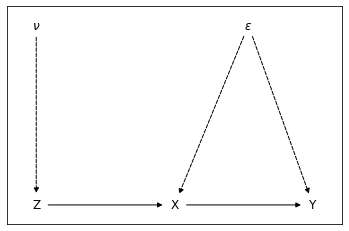

In [3]:
G = nx.DiGraph()
E_U = [("$\\epsilon$", "X"), ("$\\epsilon$", "Y"), ("$\\nu$", "Z")]
E_V = [("Z", "X"), ("X", "Y")]
G.add_edges_from(E_U + E_V)   # Add exogenous and endogenous edges to graph
pos = {'$\\epsilon$': (11.5, 5), 'X': (7.5, 0), 'Y': (15, 0), '$\\nu$': (0, 5), 'Z': (0, 0)}
_ = nx.draw_networkx_labels(G, pos)   # Plot node labels
sty = {"min_source_margin": 12, "min_target_margin": 12}         # Set min distance from labels
_ = nx.draw_networkx_edges(G, pos, E_U, style="dashed", **sty)   # Plot dashed exogenous edges
_ = nx.draw_networkx_edges(G, pos, E_V, style="solid", **sty)    # Plot solid endogenous edges

In [4]:
def sample_data(size: int = int(1e6), seed: int = 31):
    # Set random generator seed for results reproducibility
    np.random.seed(seed)
    # Sample nu from normal distribution
    nu = np.random.normal(0, 1, size)
    # Compute Z from nu
    Z = 2 * nu
    # Sample epsilon from normal distribution
    epsilon = np.random.normal(0, 9, size)
    # Sample epsilon from normal distribution
    X = 3 * Z + epsilon
    # Compute Y given X and epsilon
    Y = 5 * X + epsilon     # The true ACE is 5
    # Create a dataframe from sampled variables
    return pd.DataFrame({"X": X, "Y": Y, "Z": Z})

In [5]:
D = sample_data()
D.describe()

,X,Y,Z
count,1000000.000000,1000000.000000,1000000.000000
mean,-0.015275,-0.093012,0.000454
std,10.816713,61.779661,1.997407
min,-49.894257,-276.612154,-9.614233
25%,-7.312498,-41.753417,-1.348919
50%,-0.007989,-0.084033,0.003694
75%,7.280685,41.584162,1.349117
max,50.417261,281.971526,9.086927


In [6]:
# Cast to Numpy arrays.
X = np.atleast_2d(D["X"].to_numpy()).T
Y = D["Y"].to_numpy().T
Z = np.atleast_2d(D["Z"].to_numpy()).T

## Introduction

### Instrumental Variables Estimator (IV)

Recall that a linear model can be expressed as:

$\mathbf{y} = \beta_0 \cdot \mathbf{1} + \beta_1 \cdot \mathbf{x_1} + \cdots + \beta_n \cdot \mathbf{x_n} + \pmb{\varepsilon}$

where $\mathbf{1}, \mathbf{x}, \mathbf{y}$ and $\pmb{\varepsilon}$ are ($m \times 1$) vectors, i.e. *column* vectors, or in matrix form:

$\mathbf{y} = \mathbf{X}\pmb{\beta} + \pmb{\varepsilon}$

The objective is to estimate the parameters $\pmb{\beta}$ of the linear model (i.e. fit the linear regression estimator).

To do so, one might be tempted to premultiply by ${\color{blue}{\mathbf{X}^{-1}}}$ to remove the ${\color{red}{\mathbf{X}}}$ term, since $\mathbf{A}\mathbf{A}^{-1} = \mathbf{I}$:

${\color{blue}{\mathbf{X}^{-1}}}\mathbf{y} = {\color{blue}{\mathbf{X}^{-1}}}{\color{red}{\mathbf{X}}}\pmb{\beta} + {\color{blue}{\mathbf{X}^{-1}}}\pmb{\varepsilon}$

Then, to allow computation given the observed data, apply the expected operator $\mathbb{E}$:

$\mathbb{E}[\mathbf{X}^{-1}\mathbf{y}] = \mathbb{E}[\pmb{\beta} + \mathbf{X}^{-1}\pmb{\varepsilon}]$

Given linearity of expectation:

$\mathbf{X}^{-1}\mathbf{y} = \pmb{\beta} + {\color{red}{\mathbb{E}[\mathbf{X}^{-1}\pmb{\varepsilon}]}}$

But here is the catch: we do not observe $\pmb{\varepsilon}$ by its very definition of *noise*, therefore we cannot compute ${\color{red}{\mathbb{E}[\mathbf{X}^{-1}\pmb{\varepsilon}]}}$.

If $\mathbf{X}$ were indpendent from $\pmb{\varepsilon}$ then expectation would have been zero, but in this scenario we know that $\mathbf{X}$ is *confounded* by $\pmb{\varepsilon}$.

We need to leverage the definition of *instrumental variables* to isolate $\pmb{\beta}$ effectively.

We construct a matrix $\mathbf{Z}$ that is an exact copy of $\mathbf{X}$ *except* we replace each confounded variable $X_i$ with its instrument $Z_i$.

Then, restarting from the beginning, premultiply by ${\color{blue}{\mathbf{Z}'}}$ each term:

${\color{blue}{\mathbf{Z}'}}\mathbf{y} = {\color{blue}{\mathbf{Z}'}}\mathbf{X}\pmb{\beta} + {\color{blue}{\mathbf{Z}'}}\pmb{\varepsilon}$

Observe that by multipling $\mathbf{X}$ by $\mathbf{Z}^{-1}$ the resulting $\mathbf{Z}'\mathbf{X}$ is square, which is not true if multiplied by $\mathbf{Z}$. This will be important later on.

Apply the expected operator $\mathbb{E}$:

$\mathbf{Z}'\mathbf{y} = \mathbf{Z}'\mathbf{X}\pmb{\beta} + {\color{red}{\mathbb{E}[\mathbf{Z}'\pmb{\varepsilon}]}}$

Since $\mathbf{Z}$ is not correlated with $\pmb{\varepsilon}$ by definition of instrumental variable, ${\color{red}{\mathbb{E}[\mathbf{Z}'\pmb{\varepsilon}]}}$ is zero, therefore:

$\mathbf{Z}'\mathbf{y} = \mathbf{Z}'\mathbf{X}\pmb{\beta}$

Since ${\color{red}{\mathbf{Z}'\mathbf{X}}}$ is square and the objective is to isolate $\pmb{\beta}$, premultiply by ${\color{blue}{(\mathbf{Z}'\mathbf{X})^{-1}}}$ to get rid of ${\color{red}{\mathbf{Z}'\mathbf{X}}}$:

${\color{blue}{(\mathbf{Z}'\mathbf{X})^{-1}}}\mathbf{Z}'\mathbf{y} = {\color{blue}{(\mathbf{Z}'\mathbf{X})^{-1}}}{\color{red}{\mathbf{Z}'\mathbf{X}}}\pmb{\beta}$

By definition $\mathbf{A}\mathbf{A}^{-1} = \mathbf{I}$, hence, symmetrically, ${\color{blue}{(\mathbf{Z}'\mathbf{X})^{-1}}}{\color{red}{\mathbf{Z}'\mathbf{X}}} = \mathbf{I}$:

$(\mathbf{Z}'\mathbf{X})^{-1}\mathbf{Z}'\mathbf{y} = \pmb{\beta}$

By replacing the variables with their observations we obtain an estimate of $\pmb{\beta}$:

$\hat{\pmb{\beta}}_{IV} = (\mathbf{Z}'\mathbf{X})^{-1}\mathbf{Z}'\mathbf{y}$

### Two-Stage Least Squares Estimator (2SLS)

As before, the regression formula for $\mathbf{X}$ is expressed directly in function of $\mathbf{Z}$:

$\mathbf{X} = \mathbf{Z} \pmb{\alpha} + \pmb{\nu}$

The estimate of $\hat{\pmb{\alpha}}$ is derived from the above formula:

$\hat{\pmb{\alpha}} = (\mathbf{Z}'\mathbf{Z})^{-1}\mathbf{Z}'\mathbf{X}$

Using the estimated $\hat{\pmb{\alpha}}$, compute the estimate of $\hat{\mathbf{X}}$:

$\hat{\mathbf{X}} = \mathbf{Z}\hat{\pmb{\alpha}}$

Finally, the second stage is obtained by plugging in $\hat{\mathbf{X}}$ into the IV estimator $\hat{\pmb{\beta}}_{IV} = (\mathbf{Z}'\mathbf{X})^{-1}\mathbf{Z}'\mathbf{y}$, as:

$\hat{\pmb{\beta}}_{2SLS} = (\hat{\mathbf{X}}'\mathbf{X})^{-1}\hat{\mathbf{X}}'\mathbf{y}$

## Implementation

We can implement $\hat{\pmb{\beta}}_{IV}$ and $\hat{\pmb{\beta}}_{2SLS}$ directly from the equations above:

In [7]:
def instrumental_variables(
    X: np.ndarray,
    Y: np.ndarray,
    Z: np.ndarray
) -> float:
    return np.linalg.inv(Z.T @ X) @ Z.T @ Y

In [8]:
def two_stage_least_squares(
    X: np.ndarray,
    Y: np.ndarray,
    Z: np.ndarray
) -> float:
    # First stage.
    alpha = np.linalg.inv(Z.T @ Z) @ Z.T @ X
    X_hat = Z @ alpha
    # Second stage.
    return np.linalg.inv(X_hat.T @ X) @ X_hat.T @ Y

## Testing

In [9]:
true_ace = 5.0

In [10]:
pred_ace = float(sm.OLS(Y, X).fit().params)
print(f"Estimated ACE: {pred_ace:.2f}, Relative Error: {(abs((pred_ace - true_ace) / true_ace) * 100):.2f}%")

Estimated ACE: 5.69, Relative Error: 13.86%


In [11]:
pred_ace = float(instrumental_variables(X, Y, Z))
print(f"Estimated ACE: {pred_ace:.2f}, Relative Error: {(abs((pred_ace - true_ace) / true_ace) * 100):.2f}%")

Estimated ACE: 5.00, Relative Error: 0.02%


In [12]:
pred_ace = float(two_stage_least_squares(X, Y, Z))
print(f"Estimated ACE: {pred_ace:.2f}, Relative Error: {(abs((pred_ace - true_ace) / true_ace) * 100):.2f}%")

Estimated ACE: 5.00, Relative Error: 0.02%
